In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from knn import KNN
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
def replace_day_with_number(df, cols):
    """
    @param df: pandas DataFrame
    @param cols: list of columns to encode
    @return: DataFrame dengan hari diganti dengan angka 1-7
    """
    # Pemetaan hari ke angka (Senin=1, Selasa=2, dst)
    day_to_number = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7
    }

    for each in cols:
        # Mengganti nilai hari dengan angka menggunakan pemetaan
        df[each] = df[each].map(day_to_number)
    return df

def replace_traffic_situation(df, cols):
    """
    @param df: pandas DataFrame
    @param cols: list of columns to encode
    @return: DataFrame dengan hari diganti dengan angka 1-7
    """
    # Pemetaan hari ke angka (Senin=1, Selasa=2, dst)
    situation_to_number = {
        'low': 1,
        'normal': 2,
        'heavy': 3,
        'high': 4,
    }

    for each in cols:
        # Mengganti nilai hari dengan angka menggunakan pemetaan
        df[each] = df[each].map(situation_to_number)
    return df

# Fungsi untuk mengkategorikan waktu
def kategori_waktu(jam):
    if 6 <= jam < 10:
        return 0 # Pagi
    elif 10 <= jam < 15:
        return 1 # Siang
    elif 15 <= jam < 18:
        return 2 # Sore
    elif 18 <= jam < 22:
        return 3 # Malam
    else:
        return 4 # Malam Menjelang Pagi


def convert_traffic_situation_to_answer(predictions):
    """
    Mengonversi hasil prediksi angka (1, 2, 3, 4) menjadi jawaban kategori.

    @param predictions: list atau array berisi angka hasil prediksi
    @return: list atau array berisi jawaban kategori
    """
    # Pemetaan angka ke jawaban kategori
    number_to_answer = {
        1: 'low',
        2: 'normal',
        3: 'heavy',
        4: 'high'
    }

    for key, value in number_to_answer.items():
        if key == predictions:
            return value

    return None


In [3]:
dataset = pd.read_csv("dataset/Traffic.csv")
dataset.dtypes

Time                 object
Date                  int64
Day of the week      object
CarCount              int64
BikeCount             int64
BusCount              int64
TruckCount            int64
Total                 int64
Traffic Situation    object
dtype: object

In [4]:
dataset.isnull().sum()

Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64

In [5]:
dataset.columns

Index(['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation'],
      dtype='object')

In [6]:
dataset['Date'].unique()

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [7]:
dataset['Day of the week'].unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [8]:
dataset['Traffic Situation'].unique()

array(['low', 'normal', 'heavy', 'high'], dtype=object)

In [9]:
dataset['Time'].unique()

array(['12:00:00 AM', '12:15:00 AM', '12:30:00 AM', '12:45:00 AM',
       '1:00:00 AM', '1:15:00 AM', '1:30:00 AM', '1:45:00 AM',
       '2:00:00 AM', '2:15:00 AM', '2:30:00 AM', '2:45:00 AM',
       '3:00:00 AM', '3:15:00 AM', '3:30:00 AM', '3:45:00 AM',
       '4:00:00 AM', '4:15:00 AM', '4:30:00 AM', '4:45:00 AM',
       '5:00:00 AM', '5:15:00 AM', '5:30:00 AM', '5:45:00 AM',
       '6:00:00 AM', '6:15:00 AM', '6:30:00 AM', '6:45:00 AM',
       '7:00:00 AM', '7:15:00 AM', '7:30:00 AM', '7:45:00 AM',
       '8:00:00 AM', '8:15:00 AM', '8:30:00 AM', '8:45:00 AM',
       '9:00:00 AM', '9:15:00 AM', '9:30:00 AM', '9:45:00 AM',
       '10:00:00 AM', '10:15:00 AM', '10:30:00 AM', '10:45:00 AM',
       '11:00:00 AM', '11:15:00 AM', '11:30:00 AM', '11:45:00 AM',
       '12:00:00 PM', '12:15:00 PM', '12:30:00 PM', '12:45:00 PM',
       '1:00:00 PM', '1:15:00 PM', '1:30:00 PM', '1:45:00 PM',
       '2:00:00 PM', '2:15:00 PM', '2:30:00 PM', '2:45:00 PM',
       '3:00:00 PM', '3:15:00 PM', '3:3

In [10]:
# Data waktu dalam format AM/PM
waktu = ['12:00:00 AM', '12:15:00 AM', '12:30:00 AM', '12:45:00 AM',
         '1:00:00 AM', '1:15:00 AM', '1:30:00 AM', '1:45:00 AM',
         '2:00:00 AM', '2:15:00 AM', '2:30:00 AM', '2:45:00 AM',
         '3:00:00 AM', '3:15:00 AM', '3:30:00 AM', '3:45:00 AM',
         '4:00:00 AM', '4:15:00 AM', '4:30:00 AM', '4:45:00 AM',
         '5:00:00 AM', '5:15:00 AM', '5:30:00 AM', '5:45:00 AM',
         '6:00:00 AM', '6:15:00 AM', '6:30:00 AM', '6:45:00 AM',
         '7:00:00 AM', '7:15:00 AM', '7:30:00 AM', '7:45:00 AM',
         '8:00:00 AM', '8:15:00 AM', '8:30:00 AM', '8:45:00 AM',
         '9:00:00 AM', '9:15:00 AM', '9:30:00 AM', '9:45:00 AM',
         '10:00:00 AM', '10:15:00 AM', '10:30:00 AM', '10:45:00 AM',
         '11:00:00 AM', '11:15:00 AM', '11:30:00 AM', '11:45:00 AM',
         '12:00:00 PM', '12:15:00 PM', '12:30:00 PM', '12:45:00 PM',
         '1:00:00 PM', '1:15:00 PM', '1:30:00 PM', '1:45:00 PM',
         '2:00:00 PM', '2:15:00 PM', '2:30:00 PM', '2:45:00 PM',
         '3:00:00 PM', '3:15:00 PM', '3:30:00 PM', '3:45:00 PM',
         '4:00:00 PM', '4:15:00 PM', '4:30:00 PM', '4:45:00 PM',
         '5:00:00 PM', '5:15:00 PM', '5:30:00 PM', '5:45:00 PM',
         '6:00:00 PM', '6:15:00 PM', '6:30:00 PM', '6:45:00 PM',
         '7:00:00 PM', '7:15:00 PM', '7:30:00 PM', '7:45:00 PM',
         '8:00:00 PM', '8:15:00 PM', '8:30:00 PM', '8:45:00 PM',
         '9:00:00 PM', '9:15:00 PM', '9:30:00 PM', '9:45:00 PM',
         '10:00:00 PM', '10:15:00 PM', '10:30:00 PM', '10:45:00 PM',
         '11:00:00 PM', '11:15:00 PM', '11:30:00 PM', '11:45:00 PM']


# Konversi kolom 'Time' menjadi datetime (tanpa mengubah DataFrame asli)
dataset['Waktu'] = pd.to_datetime(dataset['Time'], format='%I:%M:%S %p')


# Tambahkan kolom 'Kategori Waktu' tanpa mengubah kolom lain
dataset['Kategori Waktu'] = dataset['Waktu'].dt.hour.apply(kategori_waktu)

# Hapus kolom 'Waktu' jika tidak diperlukan
dataset.drop('Waktu', axis=1, inplace=True)



In [11]:
dataset.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,Kategori Waktu
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low,4
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low,4
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low,4
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low,4
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal,4


In [12]:
dataset['Kategori Waktu'].value_counts()

Kategori Waktu
4    992
1    620
0    496
3    496
2    372
Name: count, dtype: int64

In [13]:
dataset.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,Kategori Waktu
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low,4
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low,4
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low,4
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low,4
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal,4


In [14]:
dataset = replace_day_with_number(dataset, ['Day of the week'])
dataset = replace_traffic_situation(dataset, ['Traffic Situation'])
dataset.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,Kategori Waktu
0,12:00:00 AM,10,2,31,0,4,4,39,1,4
1,12:15:00 AM,10,2,49,0,3,3,55,1,4
2,12:30:00 AM,10,2,46,0,3,6,55,1,4
3,12:45:00 AM,10,2,51,0,2,5,58,1,4
4,1:00:00 AM,10,2,57,6,15,16,94,2,4


In [15]:
print(dataset.dtypes)

Time                 object
Date                  int64
Day of the week       int64
CarCount              int64
BikeCount             int64
BusCount              int64
TruckCount            int64
Total                 int64
Traffic Situation     int64
Kategori Waktu        int64
dtype: object


In [16]:
dataset.dtypes
# dataset = dataset.drop(columns=['Time'])


Time                 object
Date                  int64
Day of the week       int64
CarCount              int64
BikeCount             int64
BusCount              int64
TruckCount            int64
Total                 int64
Traffic Situation     int64
Kategori Waktu        int64
dtype: object

In [17]:
print(dataset.map(type).nunique())
dataset.to_csv('dataset.csv', index=False)

Time                 1
Date                 1
Day of the week      1
CarCount             1
BikeCount            1
BusCount             1
TruckCount           1
Total                1
Traffic Situation    1
Kategori Waktu       1
dtype: int64


# Training

In [18]:
X = dataset[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Kategori Waktu']]
# X = dataset['Date', 'Day of the week']
y = dataset['Traffic Situation']

In [20]:
X

,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Kategori Waktu
0,10,2,31,0,4,4,39,4
1,10,2,49,0,3,3,55,4
2,10,2,46,0,3,6,55,4
3,10,2,51,0,2,5,58,4
4,10,2,57,6,15,16,94,4
...,...,...,...,...,...,...,...,...
2971,9,4,16,3,1,36,56,4
2972,9,4,11,0,1,30,42,4
2973,9,4,15,4,1,25,45,4
2974,9,4,16,5,0,27,48,4


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
print(dataset.dtypes)

Time                 object
Date                  int64
Day of the week       int64
CarCount              int64
BikeCount             int64
BusCount              int64
TruckCount            int64
Total                 int64
Traffic Situation     int64
Kategori Waktu        int64
dtype: object


In [23]:
model = KNN()

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [26]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9312080536912751
Classification Report:
               precision    recall  f1-score   support

           1       0.82      0.82      0.82        66
           2       0.94      0.94      0.94       340
           3       0.96      1.00      0.98       127
           4       0.93      0.87      0.90        63

    accuracy                           0.93       596
   macro avg       0.91      0.91      0.91       596
weighted avg       0.93      0.93      0.93       596

Confusion Matrix:
 [[ 54  12   0   0]
 [ 12 319   5   4]
 [  0   0 127   0]
 [  0   8   0  55]]


In [27]:
# Menyimpan hasil akurasi
accuracies = []
confusion_matrices = []
classification_reports = []

In [28]:
for train_index, test_index in kf.split(X):
    # Akses data dengan .iloc
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Latih model
    model.fit(X_train, y_train)

    # Prediksi dan evaluasi
    y_pred = model.predict(X_test)

    # Evaluasi setiap lipatan
    accuracies.append(accuracy_score(y_test, y_pred))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    classification_reports.append(classification_report(y_test, y_pred, output_dict=True))

In [29]:
# Evaluasi keseluruhan
print("Rata-rata Akurasi:", sum(accuracies) / len(accuracies))
print("\nConfusion Matrix dari lipatan terakhir:")
print(confusion_matrices[-1])
print("\nClassification Report dari lipatan terakhir:")
print(classification_reports[-1])

Rata-rata Akurasi: 0.9368298460323727

Confusion Matrix dari lipatan terakhir:
[[ 49  11   0   0]
 [  7 315   1   4]
 [  0   3 151   4]
 [  0   9   1  40]]

Classification Report dari lipatan terakhir:
{'1': {'precision': 0.875, 'recall': 0.8166666666666667, 'f1-score': 0.8448275862068966, 'support': 60.0}, '2': {'precision': 0.9319526627218935, 'recall': 0.963302752293578, 'f1-score': 0.9473684210526315, 'support': 327.0}, '3': {'precision': 0.9869281045751634, 'recall': 0.9556962025316456, 'f1-score': 0.9710610932475884, 'support': 158.0}, '4': {'precision': 0.8333333333333334, 'recall': 0.8, 'f1-score': 0.8163265306122449, 'support': 50.0}, 'accuracy': 0.9327731092436975, 'macro avg': {'precision': 0.9068035251575975, 'recall': 0.8839164053729724, 'f1-score': 0.8948959077798404, 'support': 595.0}, 'weighted avg': {'precision': 0.9325207191589943, 'recall': 0.9327731092436975, 'f1-score': 0.9323077447400935, 'support': 595.0}}


In [30]:
report_dict = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()

report_df

,precision,recall,f1-score,support
1,0.875000,0.816667,0.844828,60.000000
2,0.931953,0.963303,0.947368,327.000000
3,0.986928,0.955696,0.971061,158.000000
4,0.833333,0.800000,0.816327,50.000000
accuracy,0.932773,0.932773,0.932773,0.932773
macro avg,0.906804,0.883916,0.894896,595.000000
weighted avg,0.932521,0.932773,0.932308,595.000000


In [31]:
new_input = pd.DataFrame({
    'Date': [20],
    'Day of the week': ['Monday'],
    'CarCount': [1000],
    'BikeCount': [10],
    'BusCount': [10],
    'TruckCount': [0],
    'Total': [1020],
    'Kategori Waktu': [24]
})

new_input['Kategori Waktu'] = new_input['Date'].apply(kategori_waktu)

new_input = replace_day_with_number(new_input, ['Day of the week'])

new_input = new_input[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Kategori Waktu']]

prediction = model.predict(new_input)

print(f'Predicted Traffic Situation: {convert_traffic_situation_to_answer(prediction[0])}')

Predicted Traffic Situation: heavy


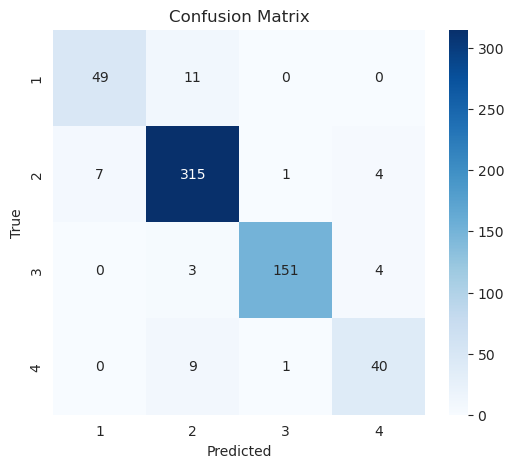

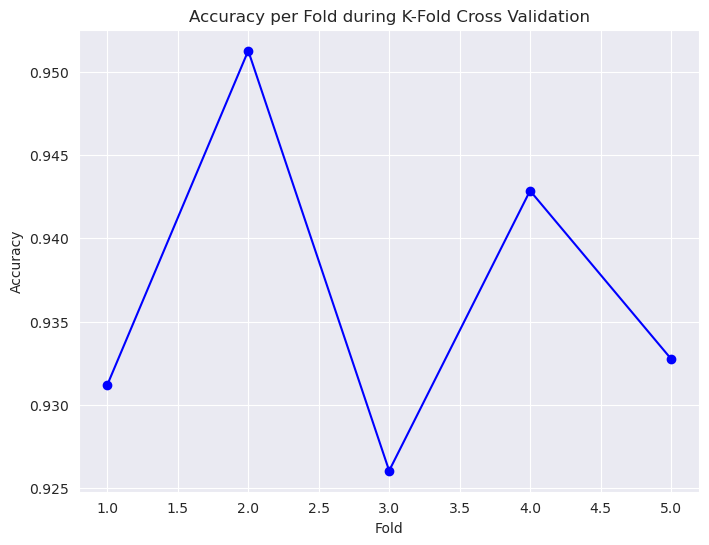

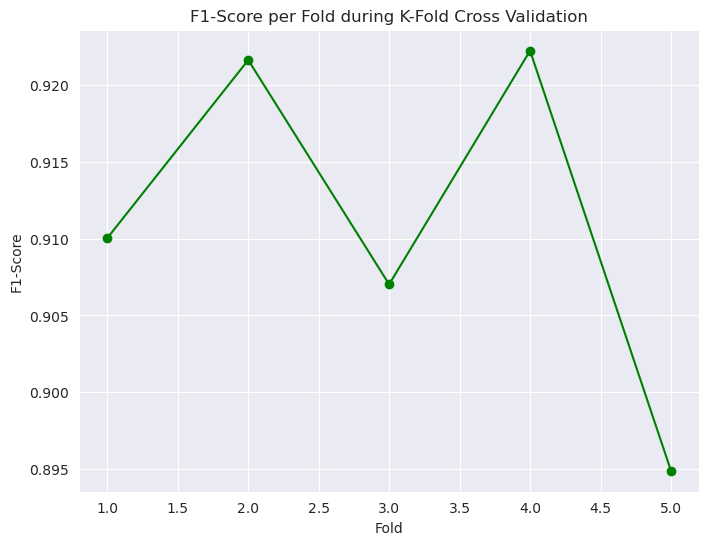

In [32]:
# Ambil label unik dari data target (y_test)
labels = np.unique(y_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualisasi Akurasi per Lipatan
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', color='b', label='Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy per Fold during K-Fold Cross Validation')
plt.grid(True)
plt.show()

# Visualisasi F1-Score untuk setiap lipatan
f1_scores = [report['macro avg']['f1-score'] for report in classification_reports]
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o', color='g', label='F1-Score per Fold')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.title('F1-Score per Fold during K-Fold Cross Validation')
plt.grid(True)
plt.show()